# Barest Soil 

### Fei Zhang @Geoscience Australia

August 2016

## Introduction

Find the barest soil Earth observations from time series analysis. The result data  will be used as input for the mineral resources uncover project:  machine-learning application.

Here are the centre point locations for 3 study aread with different vegetation/bareness relationships;

1. Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E

2. Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E

3. Woodland (remain greenish most of the time - the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E

extract a 5X5 km or 10X10km tile for each area. Then select only tiles with < 10% poor quality pixels (e.g. noise , cloud etc.). From that subset we run NDVI and then run a median kernel (3*3 ?) to smooth out noisy pixels. The kernel needs to accommodate crappy pixels as no data values. After that we calculate the average NDVI response for whole the tile. We should try a keep the tiles in chronological order because when we process all the tiles through time series and plot up the average NDVI value for each tile we will want to see trends of drying out (increased bareness) due to seasonal effects or recovery from fire scars. I suggest we look at the image tiles along each step of the work flow. There are lots of parameters (size of tile, size and shape of the kernel etc) we can change  - but as a first step this might be a good start. 

Fei we might want to have further discussions when you have selected a sub-group of tiles with good pixel quality. I suppose this first step assumes that we have a very good pixel quality mask or flag?
We have significant temporal depth - so if in doubt exclude problematic tiles.





## Interactive Computing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='BarestSoil')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Datacube Products List 
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
df_prodlist = dc.list_products()

df_prodlist.shape

(29, 15)

In [4]:
df_prodlist.head()

,name,description,product_type,sat_path,format,lon,platform,sat_row,instrument,time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
36,bom_rainfall_grids,Interpolated Rain Gauge Precipitation 1-Day Au...,rainfall,NaN,NETCDF,NaN,BoM,NaN,rain gauge,None,NaN,EPSG:4326,"[-0.05, 0.05]",None,"(latitude, longitude)"
32,dsm1sv10,DSM 1sec Version 1.0,DEM,NaN,ENVI,NaN,SRTM,NaN,SIR,None,NaN,EPSG:4326,"[-0.00027777777778, 0.00027777777778]",None,"(latitude, longitude)"
27,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til...",fractional_cover,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,level1,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",nbar,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


## Measurements List of the Products

- Each of the datacube products may have multiple measurements.

- Measurements are related to the sensors characteristics,  also known as _bands_ in the remote-sensing domain.

- _bands_ comes from electromagnetic wave spectral ranges, generally include Red-Green-Blue (RGB). 

In [5]:
df_measlist = dc.list_measurements()

df_measlist.shape

(96, 7)

In [6]:
df_measlist.head(10)

aliases    dtype flags_definition  \
product            measurement                                              
bom_rainfall_grids rainfall                 NaN  float32              NaN   
dsm1sv10           elevation                NaN  float32              NaN   
ls5_fc_albers      PV               [green_veg]     int8              NaN   
                   NPV               [dead_veg]     int8              NaN   
                   BS                    [bare]     int8              NaN   
                   UE                     [err]     int8              NaN   
ls5_nbar_albers    blue          [band_1, blue]    int16              NaN   
                   green        [band_2, green]    int16              NaN   
                   red            [band_3, red]    int16              NaN   
                   nir            [band_4, nir]    int16              NaN   

                                     name nodata  \
product            measurement                     
bom_rainfall_grids rainfall      rainfall   -999   
dsm1sv10           elevation    elevation    NaN   
ls5_fc_albers      PV                  PV     -1   
                   NPV                NPV     -1   
                   BS                  BS     -1   
                   UE                  UE     -1   
ls5_nbar_albers    blue              blue   -999   
                   green            green   -999   
                   red                red   -999   
                   nir                nir   -999   

                                                              spectral_definition  \
product            measurement                                                      
bom_rainfall_grids rainfall                                                   NaN   
dsm1sv10           elevation                                                  NaN   
ls5_fc_albers      PV                                                         NaN   
                   NPV                                                        NaN   
                   BS                                                         NaN   
                   UE                                                         NaN   
ls5_nbar_albers    blue         {u'wavelength': [410, 411, 412, 413, 414, 415,...   
                   green        {u'wavelength': [500, 501, 502, 503, 504, 505,...   
                   red          {u'wavelength': [580, 590, 600, 605, 610, 611,...   
                   nir          {u'wavelength': [730, 735, 740, 745, 750, 751,...   

                                  units  
product            measurement           
bom_rainfall_grids rainfall          mm  
dsm1sv10           elevation      metre  
ls5_fc_albers      PV           percent  
                   NPV          percent  
                   BS           percent  
                   UE                 1  
ls5_nbar_albers    blue               1  
                   green              1  
                   red                1  
                   nir                1

## Retrieving data


In [7]:
#To see the function signature?
#dc.load?

# Where?
# xp=(149.00, 149.20); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond

# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
#xp=(132.50, 132.60); yp=(-19.7, -19.5)  # 0.1degree =~ 10km 
# xp=(132.50, 132.60); yp=(-19.65, -19.55)

#Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
xp=(148.14, 148.24); yp=(-30.15, -30.05)

#Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
xp=(147.35, 147.45); yp=(-22.92, -22.82) 
                
# When? a time range
tp=('1980-01', '2016-12-31')

prod_type='ls5_nbar_albers'

In [8]:

nbar = dc.load(product=prod_type, x=xp, y=yp, time=tp)


The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

In [9]:
nbar

<xarray.Dataset>
Dimensions:  (time: 617, x: 458, y: 494)
Coordinates:
  * time     (time) datetime64[ns] 1986-08-19T23:27:06.500000 ...
  * y        (y) float64 -2.552e+06 -2.552e+06 -2.552e+06 -2.552e+06 ...
  * x        (x) float64 1.556e+06 1.556e+06 1.556e+06 1.556e+06 1.556e+06 ...
Data variables:
    blue     (time, y, x) int16 380 332 356 380 356 307 405 356 308 308 332 ...
    green    (time, y, x) int16 544 494 494 494 494 494 645 645 494 494 494 ...
    red      (time, y, x) int16 650 605 605 605 561 605 739 783 694 561 561 ...
    nir      (time, y, x) int16 1620 1620 1620 1620 1672 1621 1724 1879 1828 ...
    swir1    (time, y, x) int16 2007 1897 1970 1934 1897 1860 2154 2154 2044 ...
    swir2    (time, y, x) int16 1340 1231 1285 1231 1285 1176 1394 1557 1394 ...
Attributes:
    crs: EPSG:3577

We can look at the data by name directly, or through the `data_vars` dictionary:

In [10]:
nbar.data_vars

Data variables:
    blue     (time, y, x) int16 380 332 356 380 356 307 405 356 308 308 332 ...
    green    (time, y, x) int16 544 494 494 494 494 494 645 645 494 494 494 ...
    red      (time, y, x) int16 650 605 605 605 561 605 739 783 694 561 561 ...
    nir      (time, y, x) int16 1620 1620 1620 1620 1672 1621 1724 1879 1828 ...
    swir1    (time, y, x) int16 2007 1897 1970 1934 1897 1860 2154 2154 2044 ...
    swir2    (time, y, x) int16 1340 1231 1285 1231 1285 1176 1394 1557 1394 ...

In [11]:
nbar.green

<xarray.DataArray 'green' (time: 617, y: 494, x: 458)>
array([[[ 544,  494,  494, ...,  396,  396,  396],
        [ 544,  544,  494, ...,  447,  396,  396],
        [ 544,  595,  544, ...,  447,  447,  396],
        ..., 
        [ 548,  548,  497, ...,  804,  905,  955],
        [ 497,  447,  497, ...,  804,  855,  905],
        [ 497,  396,  497, ...,  804,  804,  855]],

       [[ 596,  547,  547, ...,  353,  402,  353],
        [ 596,  645,  596, ...,  353,  402,  353],
        [ 498,  547,  547, ...,  402,  353,  402],
        ..., 
        [ 500,  500,  500, ...,  747,  795,  893],
        [ 500,  451,  500, ...,  795,  795,  844],
        [ 549,  402,  500, ...,  795,  747,  844]],

       [[ 693,  693,  693, ...,  461,  402,  461],
        [ 693,  693,  693, ...,  461,  402,  402],
        [ 693,  752,  752, ...,  461,  461,  402],
        ..., 
        [ 521,  579,  579, ...,  697,  697,  814],
        [ 521,  521,  638, ...,  697,  697,  755],
        [ 579,  462,  579, ..., 

In [12]:
print(nbar.red.shape)

print(nbar.green.shape)

print(nbar.blue.shape)

print(nbar.swir1.shape)  # short wave Length Infrared sensor

(617, 494, 458)
(617, 494, 458)
(617, 494, 458)
(617, 494, 458)


In [13]:
print(nbar.time.min())

print(nbar.time.max())


<xarray.DataArray 'time' ()>
numpy.datetime64('1986-08-20T09:27:06.500000000+1000')
<xarray.DataArray 'time' ()>
numpy.datetime64('2011-11-13T10:53:10.000000000+1100')


## Create and Display a multi-band image

###  select a time-slice of the imagery stack
###  use pandas-style slicing to select a time period

In [14]:
itime=1

def show_images(nbar, itime):
    
    print ("Showing images acquired in datetime ", nbar.time.values[itime])
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(16,14) )
    
    plt.subplot( 1,3,1 )
    plt.imshow(red_img)#, cmap='gray')
    plt.title("Red band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='red sensor measurement');

    
    plt.subplot( 1,3,2 )
    plt.imshow(green_img)   # plotting the subset data directly
    #plt.imshow(green_img, cmap='gray')
    plt.title("Green band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='green sensor measurement');


    plt.subplot( 1,3,3 )
    plt.imshow(blue_img)   # plotting the subset data directly
    #plt.imshow(blue_img, cmap='gray')
    plt.title("Blue band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='blue sensor measurement');

    return


('Showing images acquired in datetime ', numpy.datetime64('1986-08-27T09:33:01.500000000+1000'))


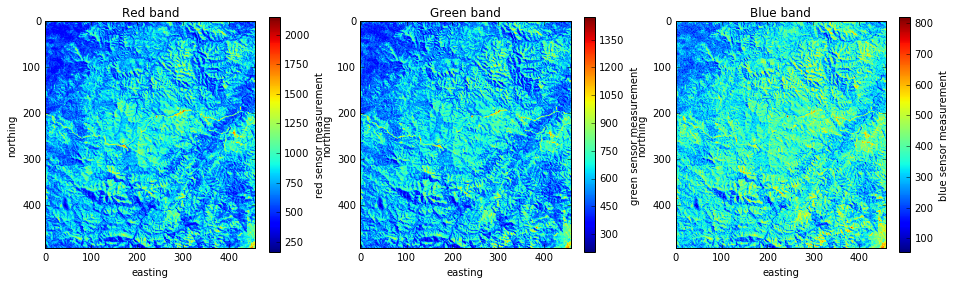

In [15]:
# show the images of bands at itime=0,1, 10

show_images(nbar, 1)

Each band is a grayscale image. They can be combined to make a better image.

In [16]:
# define a scale function to strech an image 

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    """
    Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    replacing 'nan_val' values with NaN's.
    #f_arr = 1.0*arr #.astype('float')    # required for NaN's 
    """
  
    f_arr = arr.astype('float')
    #f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    
    return f_arr


In [17]:
def make_rgb_images(nbar, itime):
    """
    Create a RGB image using bands acquired at itime
    """
    print ("RGB image acquired in datetime ", nbar.time.values[itime])
        
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(10,10) )
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)
    y_size = red_img.shape[0]; x_size = red_img.shape[1]

    print (y_size,x_size)
    #print red_img.shape

    sB1data = scale_array(red_img, 99.0, 0, 255, -999)
    sB2data = scale_array(green_img, 99.0, 0, 255, -999)
    sB3data = scale_array(blue_img, 99.0, 0, 255, -999)


    rgb_image = np.zeros((y_size, x_size, 3), dtype='uint8')
    rgb_image[:,:,0] = sB1data; 
    rgb_image[:,:,1] = sB2data; 
    rgb_image[:,:,2] = sB3data

    plt.imshow(rgb_image, interpolation='none') 
    title_str= 'Landsat Image over the Area: %s, %s'% (str(xp), str(yp))
    plt.title(title_str)
    plt.ylabel('northing'); plt.xlabel('easting');

('RGB image acquired in datetime ', numpy.datetime64('1987-09-24T09:32:41.500000000+1000'))
(494, 458)


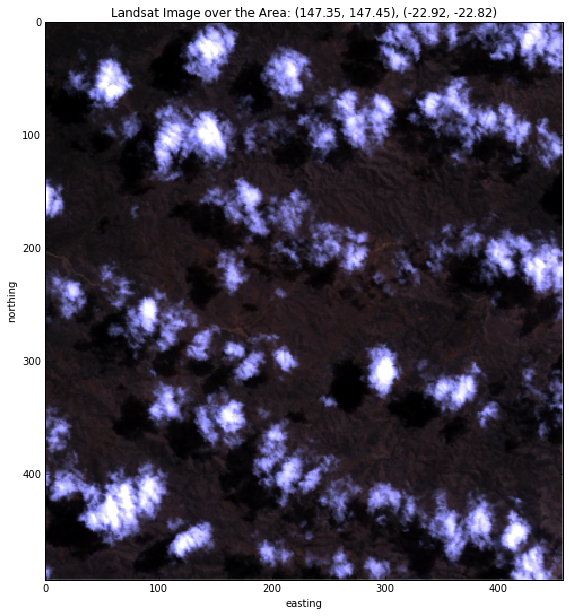

In [18]:
# good images: 3,4, 6
# cloudy images: itime=0,1
# no-data blank tiles: 2,5

make_rgb_images(nbar, 6)

## Group  by solar day function

- There is a bit of overlap between two adjacent scenes ("cut").
- To remove the overlap duplication, we combine the data slices with datetimes less than a minute apart.  


In [19]:
nbar_by_solar_day = dc.load(product=prod_type, x=xp, y=yp, time=tp, group_by='solar_day')
len(nbar_by_solar_day.time)

617

Now we have fewer timeslices than found previously without solar-day-grouping

According to Landsat cycle 16 days, 365/16 = 22 re-visit a place at least per year 

(For some region like Canberra, there will be overlap between passes)
Can be checked in the Clear Observation Layer at: http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm

('Showing images acquired in datetime ', numpy.datetime64('1986-08-20T10:00:00.000000000+1000'))


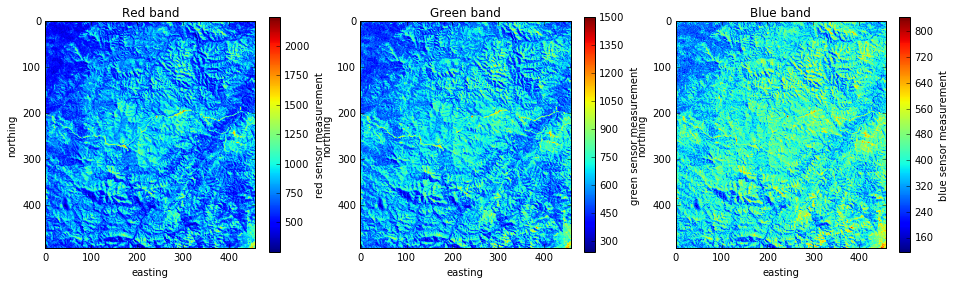

In [20]:
# show the images of bands at itime=0,1,2,3,4,... 10

show_images(nbar_by_solar_day, 0)

## Clear-sky images and cloudy images, we have to deal with in AGDC


('RGB image acquired in datetime ', numpy.datetime64('1987-05-26T10:00:00.000000000+1000'))
(494, 458)


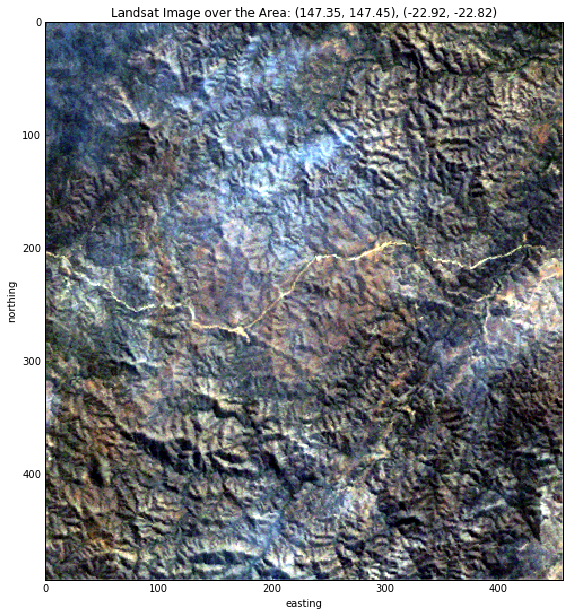

In [21]:
# 0, 5, 8 not cloudy
# 1,2,3,4 cloudy day
make_rgb_images(nbar_by_solar_day, 2 )

##  Applications based on AGDC

### Derive information products 
### Must identify and remove invalid observations: cloud, shadow, satuared pixels

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

In [22]:
prod_type

'ls5_nbar_albers'

In [23]:

blist= ['red', 'nir'] #, 'green', 'swir1']
bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, measurements= blist, group_by='solar_day')
red = bands.red.where(bands.red != bands.red.attrs['nodata'])
nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])
                    
# green = bands.green.where(bands.green != bands.green.attrs['nodata'])
# swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])

# Retrieve the associated Pixel Quality datasets ls8_pq_albers
pq_prod_type = prod_type.replace('nbar','pq')
pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day')




In [24]:
#from datacube.storage import masking

print (len(bands.time), len(pq.time))

cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality


(617, 617)


### Compute Indexes: NDVI and NDWI

#### Numpy array arithmetics without looping

In [25]:

# Normalized Differenc Vegetation Index: Red and near Infrared bands

ndvi = ((nir - red) / (nir + red)).where(cloud_free)

# Normalized Differenc Water Index: Green and Shortwave Infrared Bands

#ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

#ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

ndvi.shape


(617, 494, 458)

In [26]:
# skip ndvi plots 
#ndvi.plot(col='time', col_wrap=6)

###  Weed out the low quality images.

In [27]:
# xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels

cloudfreeRatio = 0.9  # threshold of cloud pixel 80%

mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

print(mostly_cloud_free)

<xarray.DataArray 'pixelquality' (time: 617)>
array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True, False, False,  True, False, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True,  True,  T

In [28]:
# How many images selected?

mostly_cloud_free.sum().values

array(411)

In [29]:
# Apply the time-dim mask to the 3D-array (time, x, y)
mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
# mostly_good_ndvi.plot(col='time', col_wrap=5)

In [30]:
#xarray:  mostly_good_ndvi

ndvi_mean=mostly_good_ndvi.mean(dim=['x','y'])

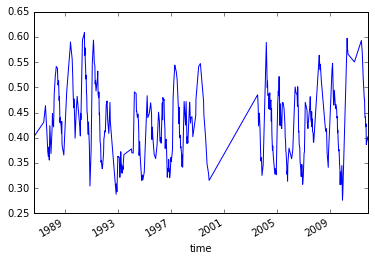

In [31]:
ndvi_mean.plot()

In [32]:
ndvi_mean

<xarray.DataArray (time: 411)>
array([ 0.38741545,  0.40207568,  0.43075669,  0.46380811,  0.40856353,
        0.37241791,  0.36319217,  0.38151716,  0.35577073,  0.42409966,
        0.36890685,  0.42290531,  0.4482425 ,  0.42574754,  0.43219237,
        0.42168072,  0.48412311,  0.52398519,  0.52849444,  0.54151788,
        0.53811651,  0.52129272,  0.50491345,  0.51353282,  0.4737226 ,
        0.48231358,  0.44955192,  0.42995963,  0.43979329,  0.43061101,
        0.42296394,  0.4090295 ,  0.43262097,  0.3867296 ,  0.37827144,
        0.3765426 ,  0.36572122,  0.49170289,  0.5797765 ,  0.59016475,
        0.55583721,  0.51937214,  0.49093725,  0.45982765,  0.47723123,
        0.44778122,  0.41620218,  0.39927962,  0.4551105 ,  0.48232405,
        0.42259134,  0.40355029,  0.44866334,  0.4358846 ,  0.58993698,
        0.59615114,  0.60480857,  0.60879122,  0.56381211,  0.5785731 ,
        0.55003505,  0.54086939,  0.51661169,  0.52401751,  0.48927702,
        0.48380802,  0.44978158, 

In [33]:
stop here

#http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
>>> from skimage import data
>>> from skimage.morphology import disk
>>> from skimage.filters.rank import median
>>> img = data.camera()
>>> med = median(img, disk(5))

SyntaxError: invalid syntax (<ipython-input-33-d67ea3c8f5f4>, line 1)

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm
